In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle

rectangular_ = 1
elliptic_ = 2

nCore_y = 2
nCore_z = 2
nturn = 512  # each period

In [2]:
emitGeomRMS = 3.3e-6
dE = 2.0e-3
pipe = 0.025

In [3]:
NL_t = 0.4
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

# read Aperture

In [4]:
beam,lattice = impact.readInputFile('../test.Chad.in')
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg

reading ImpactZ input file (../test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
ap1_x,ap1_y = 4e-3, 5.5e-3
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

# prepare test particles

In [6]:
nx = 100
testP = 0.0
sig = 0.015
k=1
q_m = beam.multi_charge.q_m[0]
pTest = []
for x in np.linspace(-ap1_x*1.2,ap1_x*1.2,100):
    for y in np.linspace(-ap1_y*1.2,ap1_y*1.2,100):
        if (x/ap1_x)**2 + (y/ap1_y)**2 <= 1.2**2:
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])    
            k=k+1
            
pTest = np.array(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

npt = len(pTest)
beam.n_particles = npt
npt

7668

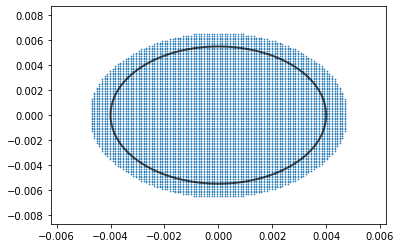

In [7]:
plt.scatter(pTest[:,0],pTest[:,2],s=0.4)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)

# ready to run

In [8]:
def getDA_data(deco,order=3):
    
    # read file
    beam,lattice = impact.readInputFile('test_'+deco+'.in')
    beam.nCore_y=nCore_y
    beam.nCore_z=nCore_z
    beam.n_particles = npt
    ke = beam.kinetic_energy
    mass = beam.mass
    freq = beam.frequency
    
    
    # adjust kick number
    cleanLat = impact.clearLattice(lattice)
    for item in cleanLat:
        if item.type == 'RFkick':
            item.vmax = 0.0
        if 'length' in item:
            item.n_sckick = int(np.ceil(item.length*50))
            item.n_map = 1
        if 'pipe_radius' in item and item.type is not 'dipole':
            item.pipe_radius = pipe
            
    for iNL,elem in enumerate(cleanLat):
        if 'nonlinear' in elem.type:
            break
    
    NL0 = impact.getElem('nonlinear_insert_sliced')
    
    NL0.length = 0.9
    NL0.start_position = 0.0
    NL0.total_length = 1.8
    
    NL0.tune_advance = 0.3
    NL0.strength_t = 0.4
    NL0.transverse_scale_c = 0.01
    
    NL0.n_map = 45
    NL0.n_sckick = 1
    
    NL1 = copy(NL0)
    NL1.start_position = 0.9
    
#     cleanLat =  [NL1] + cleanLat[iNL+1:] + cleanLat[:iNL] + [NL0]
    

    # add QFF
    cleanLat = impact.addHardEdgeQuad(cleanLat)
      
    
    # ==== run foward (from injection point) ====
    loop = impact.getElem('loop')
    loop.turns = nturn*2
    
    TBT = impact.getElem('TBT')
    TBT.pID_begin = 1
    TBT.pID_end   = npt
    TBT.file_id   = nturn*2
    
   
    beam.distribution.distribution_type = 'ReadFile'
    
    lattice = [loop,TBT]+cleanLat
      
    impact.writeInputFile(beam, lattice)
    impact.run(beam,order=order)
     
    return impact.readTBT(nturn*2,ke,mass,freq)

# Run and collect data

In [9]:
# data = {}
data = pickle.load(open('TBT_iota_v8_4_variousSextSettings.pickle','rb'))

In [10]:
deco = 'iota_v8_4_SextOff_NLon'
if deco not in data.keys():
    data[deco]=getDA_data(deco)
    pickle.dump(data,open('TBT_iota_v8_4_variousSextSettings.pickle','wb'))

In [11]:
deco = 'iota_v8_4_SextOn_NLon'
if deco not in data.keys():
    data[deco]=getDA_data(deco)
    pickle.dump(data,open('TBT_iota_v8_4_variousSextSettings.pickle','wb'))

In [12]:
deco = 'iota_v8_4_SextGoodDA_NLon'
if deco not in data.keys():
    data[deco]=getDA_data(deco)
    pickle.dump(data,open('TBT_iota_v8_4_variousSextSettings.pickle','wb'))

# Data Anal

In [23]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [24]:
deco = 'iota_v8_4_SextOff_NLon'
ind = data[deco][0]
tbt = data[deco][1]

In [25]:
npt = len(tbt[0,0,:])
Diff = np.zeros(npt)
for i in range(npt):
    signal = tbt[:nturn,0,i] - 1j*tbt[:nturn,1,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,0,i] - 1j*tbt[nturn:,1,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    xdiff = getClosestDiff(tune0,tune1)
    
    signal = tbt[:nturn,2,i] - 1j*tbt[:nturn,3,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,2,i] - 1j*tbt[nturn:,3,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    ydiff = getClosestDiff(tune0,tune1)
    
    Diff[i] = np.log10( np.sqrt(xdiff**2 +ydiff**2) +1.0e-6)

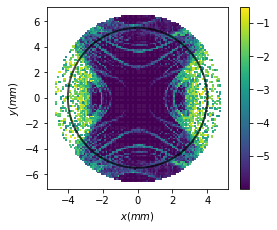

In [26]:
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(tbt[0,0,:]*1e3,tbt[0,2,:]*1e3,c=Diff,s=1.6,marker='s')
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
plt.xlabel('$x (mm)$')
plt.ylabel('$y (mm)$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA_'+deco+'.png',dpi=180)

In [27]:
deco = 'iota_v8_4_SextOn_NLon'
ind = data[deco][0]
tbt = data[deco][1]

In [28]:
npt = len(tbt[0,0,:])
Diff = np.zeros(npt)
for i in range(npt):
    signal = tbt[:nturn,0,i] - 1j*tbt[:nturn,1,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,0,i] - 1j*tbt[nturn:,1,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    xdiff = getClosestDiff(tune0,tune1)
    
    signal = tbt[:nturn,2,i] - 1j*tbt[:nturn,3,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,2,i] - 1j*tbt[nturn:,3,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    ydiff = getClosestDiff(tune0,tune1)
    
    Diff[i] = np.log10( np.sqrt(xdiff**2 +ydiff**2) +1.0e-6)

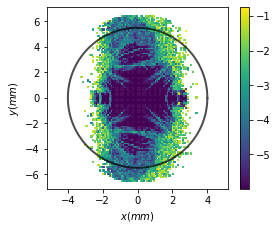

In [29]:
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(tbt[0,0,:]*1e3,tbt[0,2,:]*1e3,c=Diff,s=1.6,marker='s')
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
plt.xlabel('$x (mm)$')
plt.ylabel('$y (mm)$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA_'+deco+'.png',dpi=180)

In [30]:
deco = 'iota_v8_4_SextGoodDA_NLon'
ind = data[deco][0]
tbt = data[deco][1]

In [31]:
npt = len(tbt[0,0,:])
Diff = np.zeros(npt)
for i in range(npt):
    signal = tbt[:nturn,0,i] - 1j*tbt[:nturn,1,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,0,i] - 1j*tbt[nturn:,1,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    xdiff = getClosestDiff(tune0,tune1)
    
    signal = tbt[:nturn,2,i] - 1j*tbt[:nturn,3,i]
    signal = signal - np.mean(signal)
    tune0,amp,dummy = impact.util.naff(1,signal,window_id=1)
    signal = tbt[nturn:,2,i] - 1j*tbt[nturn:,3,i]
    tune1,amp,dummy = impact.util.naff(3,signal,window_id=1)
    ydiff = getClosestDiff(tune0,tune1)
    
    Diff[i] = np.log10( np.sqrt(xdiff**2 +ydiff**2) +1.0e-6)

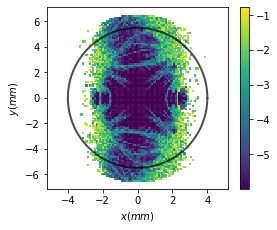

In [32]:
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(tbt[0,0,:]*1e3,tbt[0,2,:]*1e3,c=Diff,s=1.6,marker='s')
plt.plot(ap1_x*c*1e3,ap1_y*s*1e3,alpha=0.7,c='k',lw=2)
plt.xlim(-ap1_x*1.3*1e3,ap1_x*1.3*1e3)
plt.ylim(-ap1_y*1.3*1e3,ap1_y*1.3*1e3)
plt.xlabel('$x (mm)$')
plt.ylabel('$y (mm)$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('DA_'+deco+'.png',dpi=180)